In [112]:
import neuraltda.simpComp as sc
import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
from ephys import rasters
import pickle
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import seaborn as sns
from importlib import reload
import tqdm
sns.set_context('poster')
sns.set_style('white')
%matplotlib inline
reload(sa)
reload(sc)

<module 'neuraltda.simpComp' from '/home/brad/code/NeuralTDA/neuraltda/simpComp.py'>

In [147]:
nsamples2 = 10
d = 1
def loss_new(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        #KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        #JSsave.append(sc.JSdivergence(rdata, rsamp))
        KLsave.append(sc.KLdivergence(rdata, rsamp))
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def loss_new_likelihood(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        #KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        #JSsave.append(sc.JSdivergence(rdata, rsamp))
        KLsave.append(sc.Likelihood(rdata, rsamp))
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def loss_new_JS(a, beta):
    #Calculate JS according to Biam Dedom, using entropy
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        #KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        JSsave.append(sc.JSdivergence(rdata, rsamp))
        KLsave.append(sc.KLdivergence(rdata, rsamp))
    m = np.mean(KLsave)
    mJS = np.mean(JSsave)
    std = np.std(KLsave)
    stdJS = np.std(JSsave)
    stderr = std / np.sqrt(nsamples2)
    stderrJS = stdJS / np.sqrt(nsamples2)
    return (m, mJS, stderr, stderrJS)

def loss_new_KLmatlog(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        #JSsave.append(sc.JSdivergence(rdata, rsamp))
        #KLsave.append(sc.KLdivergence(rdata, rsamp))
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

In [179]:
# Generate binary matrix with given probabilities for each "cell"
ncells = 20
nwin = 1000
a = 0.03
probs = (a*np.ones((ncells, 1)))
nsamples = 1
samples = np.random.rand(ncells, nwin, nsamples)
probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
probmat = np.tile(probmat, (1, 1, nsamples))
binMatsamples = np.greater(probmat, samples).astype(int)

# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.0005, 0.08, 100)

beta = -1.0

for t in range(ntrials):
    #print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in tqdm.tqdm(X):
        #print(x)
        (m, stderr) = loss_new(x, beta)
        KL.append(m)
        KLerr.append(stderr)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

  0%|          | 0/100 [00:00<?, ?it/s]

error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error1
error2

  1%|          | 1/100 [00:00<00:27,  3.62it/s]


error1
error2
error1
error2
error2
error1
error2
error1
error2
error1
error2
error1
error2
error2


  2%|▏         | 2/100 [00:00<00:26,  3.70it/s]

error1
error2
error2
error1
error2
error1
error2
error2
error2
error2
error1
error2


  3%|▎         | 3/100 [00:00<00:25,  3.79it/s]

error1
error2
error1
error2
error2
error2
error1
error2
error1
error2
error1
error2
error2
error2
error2
error2
error1
error2
error2
error2
error1
error2
error2


  4%|▍         | 4/100 [00:01<00:25,  3.70it/s]

error2
error2
error2
error2
error2


  5%|▌         | 5/100 [00:01<00:26,  3.63it/s]

error2
error2
error1
error2
error2
error2
error2
error2


  6%|▌         | 6/100 [00:01<00:25,  3.68it/s]

error1
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2


  7%|▋         | 7/100 [00:01<00:26,  3.48it/s]

error2
error2
error2
error2
error2


  8%|▊         | 8/100 [00:02<00:28,  3.27it/s]

error2
error2
error2
error2
error2
error2
error2
error2


  9%|▉         | 9/100 [00:02<00:28,  3.22it/s]

error2
error2
error2
error2


 10%|█         | 10/100 [00:02<00:29,  3.04it/s]

error2
error2
error2
error2
error2
error2
error2
error2
error2


 11%|█         | 11/100 [00:03<00:30,  2.92it/s]

error2
error2


 12%|█▏        | 12/100 [00:03<00:31,  2.83it/s]

error2
error2
error2
error2
error2
error2


 13%|█▎        | 13/100 [00:04<00:31,  2.76it/s]

error2


 15%|█▌        | 15/100 [00:04<00:30,  2.79it/s]

error2
error2


 16%|█▌        | 16/100 [00:05<00:30,  2.78it/s]

error2
error2


 18%|█▊        | 18/100 [00:05<00:26,  3.09it/s]

error2


100%|██████████| 100/100 [01:40<00:00,  1.82s/it]


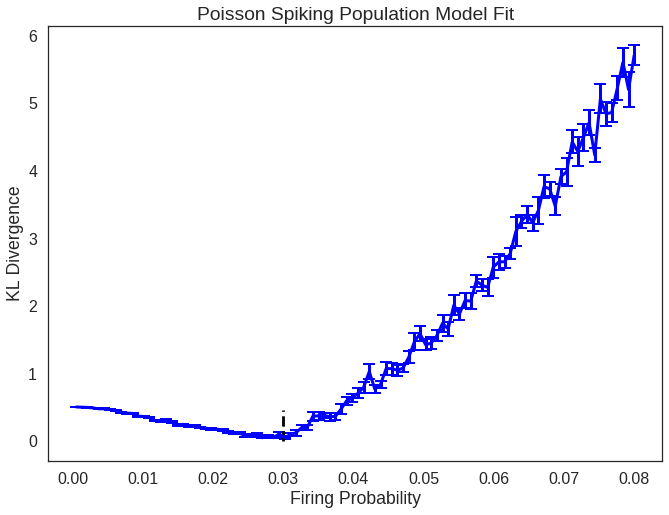

In [180]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, 0.45, 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

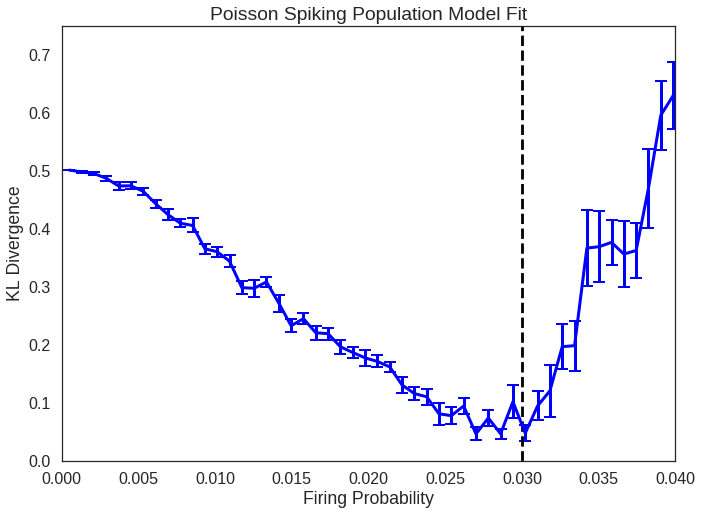

In [181]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')

plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(KL), 20), 'k--')
plt.xlim([0, 0.04])
plt.ylim(0, 0.75)
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

In [178]:
np.mean(np.sum(binMatsamples[:, :, 0], axis=1) / nwin)

0.020300000000000006

In [88]:
# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.005, 0.06, 20)

beta = -1.

#likelihood

for t in range(ntrials):
    print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in X:
        print(x)
        (m, stderr) = loss_new_likelihood(x, beta)
        KL.append(m)
        KLerr.append(stderr)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

0
0.005
error2
error2
error2
error2
error2
0.00789473684211
error2
error2
error2
0.0107894736842
error2
error2
0.0136842105263
0.0165789473684
0.0194736842105
0.0223684210526
0.0252631578947
0.0281578947368
0.0310526315789
0.0339473684211
0.0368421052632
0.0397368421053
0.0426315789474
0.0455263157895
0.0484210526316
0.0513157894737
0.0542105263158
0.0571052631579
0.06


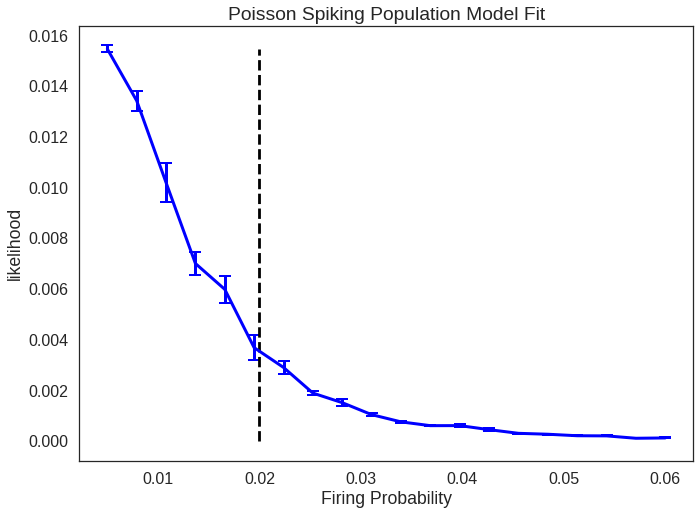

In [89]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(KL), 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('likelihood')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

In [90]:
# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.005, 0.05, 20)

beta = -1

for t in range(ntrials):
    print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in X:
        print(x)
        (m, mjs, stderr, stderrjs) = loss_new_JS(x, beta)
        KL.append(m)
        JS.append(mjs)
        KLerr.append(stderr)
        JSerr.append(stderrjs)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

0
0.005
error2
error2
error2
error2
error2
0.00736842105263
error2
error2
error2
0.00973684210526
error2
error2
0.0121052631579
0.0144736842105
0.0168421052632
0.0192105263158
0.0215789473684
0.0239473684211
0.0263157894737
0.0286842105263
0.0310526315789
0.0334210526316
0.0357894736842
0.0381578947368
0.0405263157895
0.0428947368421
0.0452631578947
0.0476315789474
0.05


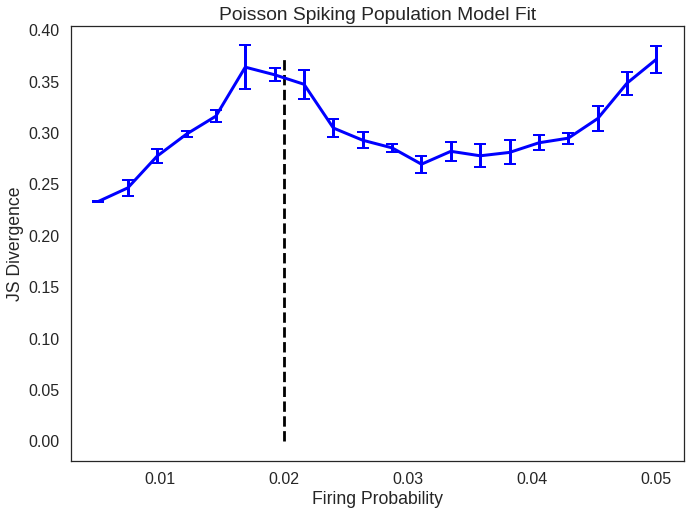

In [91]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, JS, yerr=JSerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(JS), 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('JS Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

In [105]:
# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.005, 0.05, 20)

beta = -5

for t in range(ntrials):
    print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in X:
        print(x)
        (m, stderr) = loss_new_KLmatlog(x, beta)
        KL.append(m)

        KLerr.append(stderr)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

0
0.005
error2
error2
error2
error2
error2
0.00736842105263
error2
error2
error2
error2
0.00973684210526
0.0121052631579
error2
0.0144736842105
0.0168421052632
0.0192105263158
0.0215789473684


/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:838: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


0.0239473684211
0.0263157894737
0.0286842105263
0.0310526315789
0.0334210526316
0.0357894736842
0.0381578947368
0.0405263157895
0.0428947368421
0.0452631578947
0.0476315789474
logm result may be inaccurate, approximate err = 2.68286349598064e-13
0.05


/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


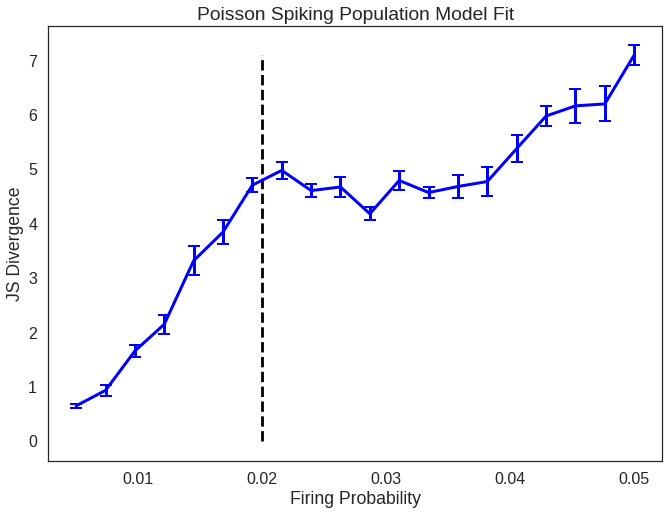

In [106]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(KL), 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('JS Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')